# Notebook Overview

This notebook will be used for demo and visualizing the dataset

## Installing and importing necessary dependencies

In [1]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 5.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.axes3d as p3
from concurrent.futures import ThreadPoolExecutor
import time
#import trimesh

In [4]:
os.chdir('/content/drive/MyDrive/TRME/')

In [5]:
!ls TRNEDataset/new_joints

00000.npy  01356.npy  02718.npy  04083.npy   M00003.npy  M01359.npy  M02721.npy  M04086.npy
00001.npy  01357.npy  02719.npy  04084.npy   M00004.npy  M01360.npy  M02722.npy  M04087.npy
00002.npy  01358.npy  02720.npy  04085.npy   M00005.npy  M01361.npy  M02723.npy  M04088.npy
00003.npy  01359.npy  02721.npy  04086.npy   M00006.npy  M01362.npy  M02724.npy  M04089.npy
00004.npy  01360.npy  02722.npy  04087.npy   M00007.npy  M01363.npy  M02725.npy  M04090.npy
00005.npy  01361.npy  02723.npy  04088.npy   M00008.npy  M01364.npy  M02726.npy  M04091.npy
00006.npy  01362.npy  02724.npy  04089.npy   M00009.npy  M01365.npy  M02727.npy  M04092.npy
00007.npy  01363.npy  02725.npy  04090.npy   M00010.npy  M01366.npy  M02728.npy  M04093.npy
00008.npy  01364.npy  02726.npy  04091.npy   M00011.npy  M01367.npy  M02729.npy  M04094.npy
00009.npy  01365.npy  02727.npy  04092.npy   M00012.npy  M01368.npy  M02730.npy  M04095.npy
00010.npy  01366.npy  02728.npy  04093.npy   M00013.npy  M01369.npy  M02731.npy 

# Viewing the dataset

In [ ]:
dataset_dir = './Dataset' #Dataset path
moyo_source = '/content/drive/MyDrive/TRME/TRNEDataset/new_joints' #New Joints path

The new joints path is required to view the motions in the npy files

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from concurrent.futures import ThreadPoolExecutor
import time

st = time.time()

def plot_3d_motion(save_path, kinematic_tree, joints, title, figsize=(10, 10), fps=120, radius=4):
    def init():
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([0, radius])
        ax.set_zlim3d([0, radius])
        fig.suptitle(title, fontsize=20)

    def plot_xzPlane(minx, maxx, miny, minz, maxz):
        ## Plot a plane XZ
        verts = [
            [minx, miny, minz],
            [minx, miny, maxz],
            [maxx, miny, maxz],
            [maxx, miny, minz]
        ]
        xz_plane = Poly3DCollection([verts])
        xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
        ax.add_collection3d(xz_plane)

    def update(index):
        ax.clear()  # Clear the previous plot elements

        # Set up the plot limits and title
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([-radius / 2, radius / 2])
        ax.set_zlim3d([-radius / 2, radius / 2])
        ax.set_title(title)

        # Add any additional plot setup here
        # Plot the XZ plane
        plot_xzPlane(MINS[0] - trajec[index, 0], MAXS[0] - trajec[index, 0],
                      0, MINS[2] - trajec[index, 1], MAXS[2] - trajec[index, 1])
        if index > 1:
            ax.plot3D(trajec[:index, 0]-trajec[index, 0], np.zeros_like(trajec[:index, 0]), trajec[:index, 1]-trajec[index, 1], linewidth=1.0,
                      color='blue')

        ax.view_init(elev=120, azim=-90)
        # Plot the joints and connect them according to the kinematic chain
        for i, (chain, color) in enumerate(zip(kinematic_tree, colors)):
            if i < 5:
                linewidth = 4.0
            else:
                linewidth = 2.0
            ax.plot3D(data[index, chain, 0], data[index, chain, 1], data[index, chain, 2], linewidth=linewidth, color=color)

        # Set axis labels and ticks
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

    data = joints.copy().reshape(len(joints), -1, 3)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    init()
    MINS = data.min(axis=0).min(axis=0)
    MAXS = data.max(axis=0).max(axis=0)
    colors = ['red', 'blue', 'black', 'red', 'blue',
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
             'darkred', 'darkred','darkred','darkred','darkred']
    frame_number = data.shape[0]
    #     print(data.shape)

    height_offset = MINS[1]
    data[:, :, 1] -= height_offset
    trajec = data[:, 0, [0, 2]]

    data[..., 0] -= data[:, 0:1, 0]
    data[..., 2] -= data[:, 0:1, 2]

    # Batch processing with parallel execution
    batch_size = 50
    num_batches = len(joints) // batch_size + (len(joints) % batch_size != 0)
    with ThreadPoolExecutor() as executor:
        futures = []
        for batch_start in range(0, len(joints), batch_size):
            batch_end = min(batch_start + batch_size, len(joints))
            frames = range(batch_start, batch_end)
            futures.append(executor.submit(update, frames[-1]))  # Submit update function for each batch

        # Wait for all futures to complete
        for future in futures:
            future.result()

    ani = FuncAnimation(fig, update, frames=len(joints), interval=1000/fps)
    ani.save(save_path, fps=fps)
    plt.close()

    et = time.time()
    print('Execution_time : ', et - st)



# Function to animate a whole directory

In [ ]:
# from tqdm import tqdm
# import os
# import numpy as np
# from IPython.display import Image, display

# # Define kinematic chain and joints data
# kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]
# data_dir = '/content/drive/MyDrive/TRME/TRNEDataset/new_joints'
# save_dir = '/content/drive/MyDrive/TRME/Dataset/TRNEDataset/animation'
# texts_dir = '/content/drive/MyDrive/TRME/Dataset/TRNEDataset/texts'

# # Create the 'texts' folder if it doesn't exist
# if not os.path.exists(texts_dir):
#     os.makedirs(texts_dir)

# # Ask the user for the batch size
# batch_size = int(input("Enter the number of files to process at a time: "))

# # Loop through the files with a progress bar, processing only the specified number of files
# file_list = [file for file in os.listdir(data_dir) if file.endswith('.npy')]
# for i in tqdm(range(0, len(file_list), batch_size), desc='Processing Batches'):
#     batch_files = file_list[i:i + batch_size]

#     # Process each file in the current batch
#     for file in batch_files:
#         name = file[:-4]  # Get the base name
#         save_name = name + '.gif'
#         save_path = os.path.join(save_dir, save_name)

#         # Load the data and create the GIF
#         sample_moyo = np.load(os.path.join(data_dir, file))
#         plot_3d_motion(save_path, kinematic_chain, sample_moyo, title="Testing", fps=25, radius=4)

#         # Display the GIF to collect user input
#         display(Image(filename=save_path))

#         # Prompt the user for a description and save it
#         description = input(f"Enter a description for the motion displayed in {save_name}: ")
#         text_file_path = os.path.join(texts_dir, name + '.txt')
#         with open(text_file_path, 'w') as f:
#             f.write(description)

#         # Delete the GIF after writing the text
#         os.remove(save_path)  # Delete the generated GIF

# print("Batch processing completed. All GIFs processed and descriptions saved.")


# Function to load a numpy file and save a GIF corresponding to it

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from concurrent.futures import ThreadPoolExecutor
import time

st = time.time()

def plot_3d_motion(save_path, kinematic_tree, joints, title, figsize=(10, 10), fps=120, radius=4):
    def init():
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([0, radius])
        ax.set_zlim3d([0, radius])
        ax.grid(False)  # Disable gridlines
        fig.suptitle(title, fontsize=20)

    def plot_xzPlane(minx, maxx, miny, minz, maxz):
        verts = [
            [minx, miny, minz],
            [minx, miny, maxz],
            [maxx, miny, maxz],
            [maxx, miny, minz]
        ]
        xz_plane = Poly3DCollection([verts])
        xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
        ax.add_collection3d(xz_plane)

    def update(index):
        ax.clear()  # Clear previous plot elements
        ax.grid(False)  # Ensure grid is off

        # Set up plot limits and title
        ax.set_xlim3d([-radius / 2, radius / 2])
        ax.set_ylim3d([-radius / 2, radius / 2])
        ax.set_zlim3d([-radius / 2, radius / 2])
        ax.set_title(title)

        # Plot the XZ plane
        plot_xzPlane(MINS[0] - trajec[index, 0], MAXS[0] - trajec[index, 0], 0, MINS[2] - trajec[index, 1], MAXS[2] - trajec[index, 1])
        if index > 1:
            ax.plot3D(trajec[:index, 0] - trajec[index, 0], np.zeros_like(trajec[:index, 0]), trajec[:index, 1] - trajec[index, 1], linewidth=1.0, color='blue')

        ax.view_init(elev=120, azim=-90)

        # Plot the joints and connect them according to the kinematic chain
        for i, (chain, color) in enumerate(zip(kinematic_tree, colors)):
            linewidth = 4.0 if i < 5 else 2.0
            ax.plot3D(data[index, chain, 0], data[index, chain, 1], data[index, chain, 2], linewidth=linewidth, color=color)

        # Hide axis labels and ticks
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xticks([])  # No ticks
        ax.set_yticks([])  # No ticks
        ax.set_zticks([])  # No ticks

    data = joints.copy().reshape(len(joints), -1, 3)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    init()
    MINS = data.min(axis=0).min(axis=0)
    MAXS = data.max(axis=0).max(axis=0)
    colors = ['red', 'blue', 'black', 'red', 'blue',
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
             'darkred', 'darkred', 'darkred', 'darkred', 'darkred']

    # Data normalization for animation
    height_offset = MINS[1]
    data[:, :, 1] -= height_offset
    trajec = data[:, 0, [0, 2]]

    data[..., 0] -= data[:, 0:1, 0]
    data[..., 2] -= data[:, 0:1, 2]

    # Use parallel processing for frame update
    batch_size = 50
    num_batches = len(joints) // batch_size + (len(joints) % batch_size != 0)
    with ThreadPoolExecutor() as executor:
        futures = []
        for batch_start in range(0, len(joints), batch_size):
            batch_end = min(batch_start + batch_size, len(joints))
            frames = range(batch_start, batch_end)
            futures.append(executor.submit(update, frames[-1]))

        for future in futures:
            future.result()

    ani = FuncAnimation(fig, update, frames=len(joints), interval=1000/fps)
    ani.save(save_path, fps=fps)
    plt.close()

    et = time.time()
    print('Execution time:', et - st)

# Test the plot_3d_motion function with mock-up parameters
##kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]
#sample_moyo = np.load(moyo_source+'/00000.npy')

#plot_3d_motion('/content/sample_data/mockup_4.gif', kinematic_chain, sample_moyo, title="Testing", fps=25, radius=4)


# Demo testing

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
cd /content/drive/MyDrive/TRME/T2M-GPT

/content/drive/.shortcut-targets-by-id/12j_isnMRlxwqT8sj2OGg4vLL85bIcNsK/TRME/T2M-GPT


In [8]:
# List of pip dependencies from the given environment
pip_dependencies = [
    "absl-py"
    "backcall",
    "cachetools",
    "charset-normalizer",
    "chumpy",
    "cycler",
    "decorator",
    "google-auth",
    "google-auth-oauthlib",
    "grpcio",
    "idna",
    "imageio",
    "ipdb",
    "ipython",
    "ipython-genutils",
    "jedi",
    "joblib",
    "kiwisolver",
    "markdown",
    "matplotlib",
    "matplotlib-inline",
    "oauthlib",
    "pandas",
    "parso",
    "pexpect",
    "pickleshare",
    "prompt-toolkit",
    "protobuf",
    "ptyprocess",
    "pyasn1",
    "pyasn1-modules",
    "pygments",
    "pyparsing",
    "python-dateutil",
    "pytz",
    "pyyaml",
    "requests",
    "requests-oauthlib",
    "rsa",
    "scikit-learn",
    "scipy",
    "sklearn",
    "smplx",
    "tensorboard",
    "tensorboard-data-server",
    "tensorboard-plugin-wit",
    "threadpoolctl",
    "toml",
    "tqdm",
    "traitlets",
    "urllib3",
    "wcwidth",
    "werkzeug",
    "gdown",
    "moviepy",
    "git+https://github.com/openai/CLIP.git",
    "git+https://github.com/nghorbani/human_body_prior",
]

# Install pip dependencies in Colab
for dependency in pip_dependencies:
    !pip install {dependency}


ERROR: Could not find a version that satisfies the requirement absl-pybackcall (from versions: none)
ERROR: No matching distribution found for absl-pybackcall
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58263 sha256=a2462c1a04c7358bae2e727483bb6d59e618443fc825a371638d38bf6cc28897
  Stored in directory: /root/.cache/pip/wheels/e0/c1/ef/29ba7be03653a29ef6f2c3e1956d6c4d8877f2b243af411db1
Successfully built chumpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metada

In [9]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py38_23.1.0-1-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...





Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local


--2024-05-11 01:35:56--  https://repo.continuum.io/miniconda/Miniconda3-py38_23.1.0-1-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.177.84, 104.18.176.84, 2606:4700::6812:b154, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.177.84|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py38_23.1.0-1-Linux-x86_64.sh [following]
--2024-05-11 01:35:56--  https://repo.anaconda.com/miniconda/Miniconda3-py38_23.1.0-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68546682 (65M) [application/x-sh]
Saving to: ‘Miniconda3-py38_23.1.0-1-Linux-x86_64.sh.2’

     0K .......... .......... .......... .......... ..........  0% 6.77M 10s
    50K .......... ........

In [10]:
# this part takes some time
%%bash
conda env create -f environment.yml

Solving environment: ...working... done

ld_impl_linux-64-2.3 | 586 KB    |            |   0% 
bzip2-1.0.8          | 78 KB     |            |   0% 

libuv-1.40.0         | 736 KB    |            |   0% 


torchaudio-0.8.1     | 4.4 MB    |            |   0% 



ninja-1.10.2         | 1.4 MB    |            |   0% 




openh264-2.1.0       | 722 KB    |            |   0% 





olefile-0.46         | 33 KB     |            |   0% 






openssl-1.1.1k       | 2.5 MB    |            |   0% 







certifi-2021.5.30    | 138 KB    |            |   0% 








lcms2-2.12           | 312 KB    |            |   0% 









jpeg-9b              | 214 KB    |            |   0% 










libgomp-9.3.0        | 311 KB    |            |   0% 











zlib-1.2.11          | 103 KB    |            |   0% 












mkl-service-2.4.0    | 59 KB     |            |   0% 













setuptools-52.0.0    | 714 KB    |            |   0% 














libpng-1.6.37        | 278 KB    |          



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0




In [42]:
!pip install ipykernel

In [1]:
cd /content/drive/MyDrive/TRME/T2M-GPT

/content/drive/.shortcut-targets-by-id/12j_isnMRlxwqT8sj2OGg4vLL85bIcNsK/TRME/T2M-GPT


In [2]:
%%bash
source activate T2M-GPT

python

In [6]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vpm_skwo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vpm_skwo
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.2.0-py3-none-any.whl (54 kB)
  Using cached regex-2024.5.10-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (777 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 92.3 MB/s eta 0:00:00
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached filelock-3.14.0-py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.9 MB/s eta 0:00:00
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [29]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 15.3 MB/s eta 0:00:00


In [55]:
%%bash
source activate T2M-GPT
python

# change the text here
clip_text = ["a person is doing a kick "]

import sys
sys.argv = ['GPT_eval_multi.py']
import options.option_transformer as option_trans
args = option_trans.get_args_parser()

args.dataname = 't2m'
args.resume_pth = './output/VQVAE_imp_resnet_100k_hml3d/net_last.pth'
args.resume_trans = './output/net_best_fid.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51
import clip
import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
import warnings
warnings.filterwarnings('ignore')

clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda'), jit=False, download_root='./')
clip.model.convert_weights(clip_model)
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

net = vqvae.HumanVQVAE(args,
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)


trans_encoder = trans.Text2Motion_Transformer(num_vq=args.nb_code,
                                embed_dim=1024,
                                clip_dim=args.clip_dim,
                                block_size=args.block_size,
                                num_layers=9,
                                n_head=16,
                                drop_out_rate=args.drop_out_rate,
                                fc_rate=args.ff_rate)


print ('loading checkpoint from {}'.format(args.resume_pth))
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
net.eval()
net.cuda()

print ('loading transformer checkpoint from {}'.format(args.resume_trans))
ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder.eval()
trans_encoder.cuda()

mean = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy')).cuda()
std = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy')).cuda()

text = clip.tokenize(clip_text, truncate=True).cuda()
feat_clip_text = clip_model.encode_text(text).float()
index_motion = trans_encoder.sample(feat_clip_text[0:1], False)
pred_pose = net.forward_decoder(index_motion)

from utils.motion_process import recover_from_ric
pred_xyz = recover_from_ric((pred_pose*std+mean).float(), 22)
xyz = pred_xyz.reshape(1, -1, 22, 3)

np.save('motion.npy', xyz.detach().cpu().numpy())

import visualization.plot_3d_global2 as plot_3d
pose_vis = plot_3d.draw_to_batch(xyz.detach().cpu().numpy(),clip_text, ['example.gif'])

loading checkpoint from /content/drive/MyDrive/TRME/T2M-GPT/pretrained/VQVAE/net_last.pth
loading transformer checkpoint from /content/drive/MyDrive/TRME/T2M-GPT/pretrained/VQTransformer_corruption05/net_best_fid.pth



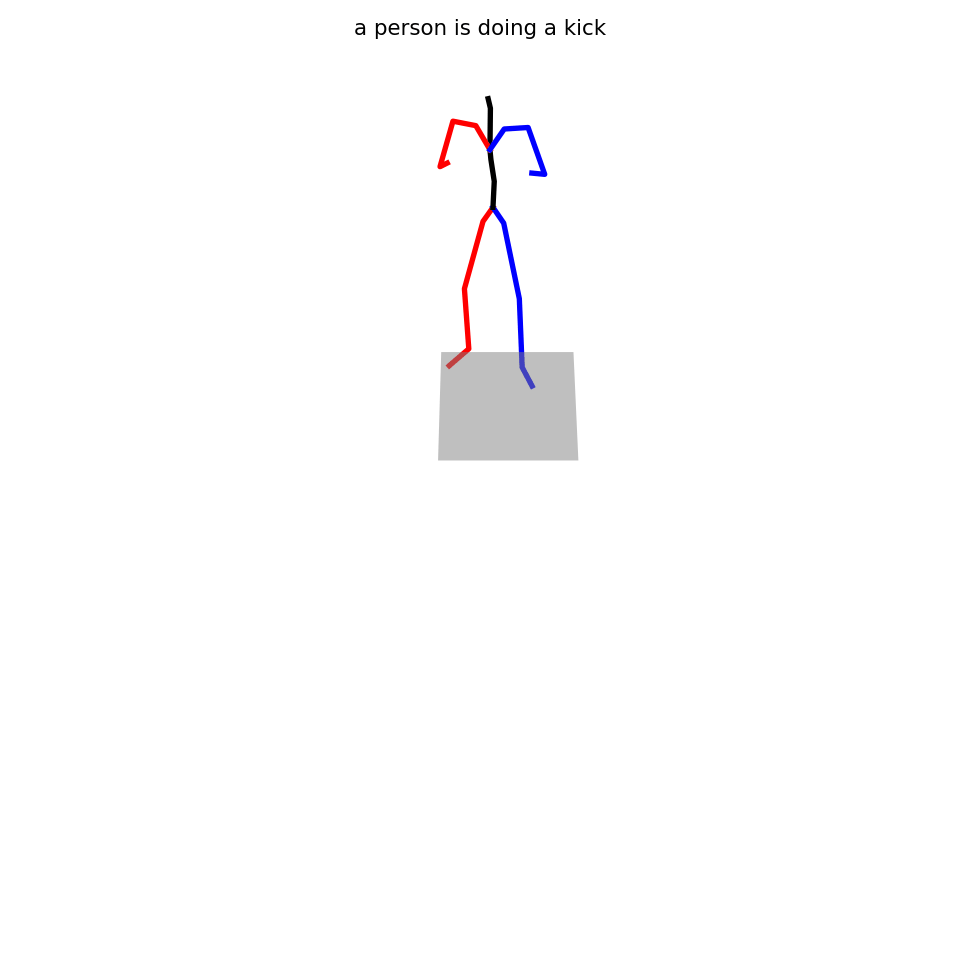

In [56]:
from IPython.display import HTML
import base64
b64 = base64.b64encode(open('example.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))